In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 剩下的w都是噪音项

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.5371],
         [0.5821]]),
 tensor([[1.0000e+00, 5.3708e-01, 1.4423e-01, 2.5821e-02, 3.4670e-03, 3.7242e-04,
          3.3336e-05, 2.5578e-06, 1.7172e-07, 1.0247e-08, 5.5037e-10, 2.6872e-11,
          1.2027e-12, 4.9690e-14, 1.9063e-15, 6.8254e-17, 2.2911e-18, 7.2385e-20,
          2.1598e-21, 6.1053e-23],
         [1.0000e+00, 5.8205e-01, 1.6939e-01, 3.2865e-02, 4.7823e-03, 5.5671e-04,
          5.4006e-05, 4.4906e-06, 3.2672e-07, 2.1130e-08, 1.2299e-09, 6.5077e-11,
          3.1565e-12, 1.4133e-13, 5.8757e-15, 2.2800e-16, 8.2941e-18, 2.8398e-19,
          9.1828e-21, 2.8131e-22]]),
 tensor([5.2078, 5.3455]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0060663  1.3059944 -3.432994   5.397027 ]]


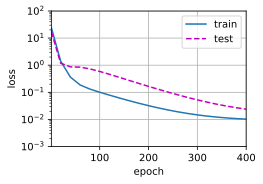

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.129354  4.2532153]]


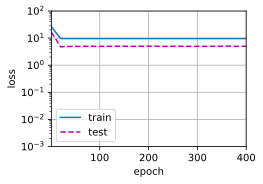

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.957412    1.3368841  -3.192587    5.109639   -0.6885348   0.7725636
  -0.03258926  0.23319618 -0.2173731  -0.15995458  0.05304306  0.20679443
   0.12560654  0.1398746  -0.17692302 -0.02886605 -0.06989998 -0.08930637
  -0.18746357  0.14101678]]


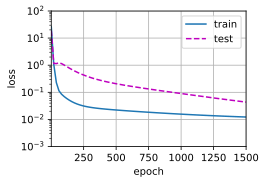

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)